In [110]:
import json
import pandas
import numpy

In [41]:
with open("../11-30-2022/6386d89efb3ff533c12df167__post10.json") as f:
    raw_data = json.load(f)

In [42]:
raw_data[0].keys()

dict_keys(['_id', 'timestamp', 'x_position', 'y_position', 'road_segment_ids', 'flags', 'length', 'width', 'height', 'merged_ids', 'fragment_ids', 'coarse_vehicle_class', 'fine_vehicle_class', 'direction', 'compute_node_id', 'local_fragment_id', 'starting_x', 'first_timestamp', 'configuration_id', 'ending_x', 'last_timestamp', 'x_score', 'y_score'])

In [43]:
raw_data[0]["y_score"]

0.20909570297063027

In [111]:
def giveAcceptedTimestamps(entry, min_timestamp, max_timestamp):
    result = [idx for idx, t in enumerate(entry["timestamp"]) if (t >= min_timestamp) and (t <= max_timestamp)]
    if len(result) == 0:
        return False, 0, 0
    return True, int(min(result)), int(max(result))    

def filterArrayByIndex(a, min_index, max_index):
    return a[min_index:(max_index + 1)]

def filterEntryByTime(entry, min_timestamp, max_timestamp):
    result = {}
    valid, min_index, max_index = giveAcceptedTimestamps(entry, min_timestamp, max_timestamp)
    if not valid:
        return None
    result["_id"] = entry["_id"]
    result["timestamp"] = filterArrayByIndex(entry["timestamp"], min_index, max_index)
    result["x_position"] = filterArrayByIndex(entry["x_position"], min_index, max_index)
    result["y_position"] = filterArrayByIndex(entry["y_position"], min_index, max_index)
    result["road_segment_ids"] = entry["road_segment_ids"]
    result["flags"] = entry["flags"]
    result["length"] = entry["length"]
    result["width"] = entry["width"]
    result["height"] = entry["height"]
    result["merged_ids"] = entry["merged_ids"]
    result["fragment_ids"] = entry["fragment_ids"]
    result["coarse_vehicle_class"] = entry["coarse_vehicle_class"]
    result["fine_vehicle_class"] = entry["fine_vehicle_class"]
    result["direction"] = entry["direction"]
    result["compute_node_id"] = entry["compute_node_id"]
    result["local_fragment_id"] = entry["local_fragment_id"]
    result["starting_x"] = result["x_position"][0]
    result["first_timestamp"] = result["timestamp"][0]
    result["configuration_id"] = entry["configuration_id"]
    result["ending_x"] = result["x_position"][-1]
    result["last_timestamp"] = result["timestamp"][-1]
    result["x_score"] = entry["x_score"]
    result["y_score"] = entry["y_score"]
    return result

def filterDatasetByTime(data, min_timestamp, max_timestamp):
    result = []
    for entry in data:
        filtered_entry = filterEntryByTime(entry, min_timestamp, max_timestamp)
        if filtered_entry is not None:
            result.append(filtered_entry)
    return result

In [45]:
time_filtered_data = filterDatasetByTime(raw_data, 1669812000, 1669812600)

In [46]:
len(time_filtered_data)

43235

In [47]:
def convertXToMarker(x):
    return x / 5280.0

def giveAcceptedMarkers(entry, min_marker, max_marker):
    result = [idx for idx, x in enumerate(entry["x_position"]) if (convertXToMarker(x) >= min_marker) and (convertXToMarker(x) <= max_marker)]
    if len(result) == 0:
        return False, 0, 0
    return True, int(min(result)), int(max(result))

def filterEntryByMile(entry, min_marker, max_marker):
    result = {}
    valid, min_index, max_index = giveAcceptedMarkers(entry, min_marker, max_marker)
    if not valid:
        return None
    result["_id"] = entry["_id"]
    result["timestamp"] = filterArrayByIndex(entry["timestamp"], min_index, max_index)
    result["x_position"] = filterArrayByIndex(entry["x_position"], min_index, max_index)
    result["y_position"] = filterArrayByIndex(entry["y_position"], min_index, max_index)
    result["road_segment_ids"] = entry["road_segment_ids"]
    result["flags"] = entry["flags"]
    result["length"] = entry["length"]
    result["width"] = entry["width"]
    result["height"] = entry["height"]
    result["merged_ids"] = entry["merged_ids"]
    result["fragment_ids"] = entry["fragment_ids"]
    result["coarse_vehicle_class"] = entry["coarse_vehicle_class"]
    result["fine_vehicle_class"] = entry["fine_vehicle_class"]
    result["direction"] = entry["direction"]
    result["compute_node_id"] = entry["compute_node_id"]
    result["local_fragment_id"] = entry["local_fragment_id"]
    result["starting_x"] = result["x_position"][0]
    result["first_timestamp"] = result["timestamp"][0]
    result["configuration_id"] = entry["configuration_id"]
    result["ending_x"] = result["x_position"][-1]
    result["last_timestamp"] = result["timestamp"][-1]
    result["x_score"] = entry["x_score"]
    result["y_score"] = entry["y_score"]
    return result

def filterDatasetByMileMarker(data, min_marker, max_marker):
    result = []
    for entry in data:
        filtered_entry = filterEntryByMile(entry, min_marker, max_marker)
        if filtered_entry is not None:
            result.append(filtered_entry)
    return result

In [48]:
time_and_marker_filtered_data = filterDatasetByMileMarker(time_filtered_data, 60.6, 61.6)

In [49]:
len(time_and_marker_filtered_data)

12809

In [50]:
with open("../selected_map_region_10_minutes.json", "w+") as f:
    json.dump(time_and_marker_filtered_data, f, indent=4)

In [51]:
with open("../selected_map_region_10_minutes.json", "r") as f:
    time_and_marker_filtered_data = json.load(f)

In [60]:
# Don't include the lane boundaries themselves
def giveAcceptedLanes(entry, min_y, max_y):
    result = [idx for idx, y in enumerate(entry["y_position"]) if (y > min_y) and (y < max_y)]
    if len(result) == 0:
        return False, 0, 0
    return True, int(min(result)), int(max(result))

def filterEntryByLane(entry, min_y, max_y, s_conversion_function, t_conversion_function):
    feet_to_meters = 0.3048
    result = {}
    valid, min_index, max_index = giveAcceptedLanes(entry, min_y, max_y)
    if not valid:
        return None
    result["_id"] = entry["_id"]
    result["timestamp"] = filterArrayByIndex(entry["timestamp"], min_index, max_index)
    result["marker"] = [x / 5280.0 for x in filterArrayByIndex(entry["x_position"], min_index, max_index)]
    result["s"] = [s_conversion_function(x) for x in filterArrayByIndex(entry["x_position"], min_index, max_index)]
    result["t"] = [t_conversion_function(y) for y in filterArrayByIndex(entry["y_position"], min_index, max_index)]
    result["length"] = entry["length"] * feet_to_meters
    result["width"] = entry["width"] * feet_to_meters
    result["height"] = entry["height"] * feet_to_meters
    result["coarse_vehicle_class"] = entry["coarse_vehicle_class"]
    result["fine_vehicle_class"] = entry["fine_vehicle_class"]
    result["direction"] = entry["direction"]
    return result

def filterDatasetByLanes(data):
    result = {}
    feet_to_meters = 0.3048
    def road1ConversionFormula(x_position):
        return ((((x_position / 5280.0) - 61.6) * 5280.0) * feet_to_meters) + 1597.2592670421188
    def road2ConversionFormula(x_position):
        return (((61.6 - (x_position / 5280.0)) * 5280.0) * feet_to_meters) + 84.01474839564042
    s_conversion_formulas = {
        "eastbound": road1ConversionFormula,
        "westbound": road2ConversionFormula
    }
    # We assume all the lanes are on the right of the reference line
    def t_conversion_function(y):
        return ((abs(y) - 12.0) * feet_to_meters) * -1
    road_data = {
        "eastbound": {"-1": [-24.0, -12.0], "-2": [-36.0, -24.0], "-3": [-48.0, -36.0], "-4": [-60.0, -48.0]},
        "westbound": {"-1": [12.0, 24.0], "-2": [24.0, 36.0], "-3": [36.0, 48.0], "-4": [48.0, 60.0]}
    }
    for road in road_data:
        result[road] = {}
        road_bounds = road_data[road]
        for lane in road_bounds:
            result[road][lane] = []
    for entry in data:
        for road in road_data:
            road_bounds = road_data[road]
            for lane in road_bounds:
                lane_bounds = road_bounds[lane]
                filtered_entry = filterEntryByLane(entry, lane_bounds[0], lane_bounds[1], s_conversion_formulas[road], t_conversion_function)
                if filtered_entry is not None:
                    result[road][lane].append(filtered_entry)
    return result

In [61]:
time_and_marker_and_lane_filtered_data = filterDatasetByLanes(time_and_marker_filtered_data)

In [62]:
with open("../selected_map_region_10_minutes_opendrive.json", "w+") as f:
    json.dump(time_and_marker_and_lane_filtered_data, f, indent=4)

In [102]:
with open("../selected_map_region_10_minutes_opendrive.json", "r") as f:
    time_and_marker_and_lane_filtered_data = json.load(f)

In [109]:
def computeVelocities(data, road, lane):
    velocities = []
    for entry in data[road][lane]:
        current_s_diff = numpy.array(entry["s"][1:]) - numpy.array(entry["s"][:-1])
        current_timestamp_diff = numpy.array(entry["timestamp"][1:]) - numpy.array(entry["timestamp"][:-1])
        current_velocities = (current_s_diff / current_timestamp_diff).tolist()
        velocities.extend(current_velocities)
    return velocities

for road in time_and_marker_and_lane_filtered_data:
    for lane in time_and_marker_and_lane_filtered_data[road]:
        velocities = computeVelocities(time_and_marker_and_lane_filtered_data, road, lane)
        print(road, lane, numpy.min(velocities), numpy.mean(velocities), numpy.max(velocities), numpy.std(velocities), numpy.quantile(velocities, 0.99))


eastbound -1 -18.293742017554067 33.845668196898956 158.94357931581237 8.178595639970768 42.18229278136921
eastbound -2 -30.50229771779437 31.858855191570417 150.61134724240642 6.504787021229073 40.50136727992312
eastbound -3 -29.338586085554873 29.64470027581563 140.54045646685694 6.367676869047217 39.25375369457882
eastbound -4 -21.072031490119496 27.8685721712349 125.88591651407982 5.984876155775832 36.18969829718853
westbound -1 -110.05919766764161 8.638130034982346 61.23298275535251 5.9015022225308105 21.008667598856142
westbound -2 -108.77902088697793 9.533743314766486 62.1293032362212 5.580388101352936 21.762668658694455
westbound -3 -108.16323112897905 9.306938242421717 62.04720773118975 4.984766160138556 20.95365210238203
westbound -4 -107.61063728595592 9.104377556427798 60.04708094861526 4.200320146223515 18.265792931892037


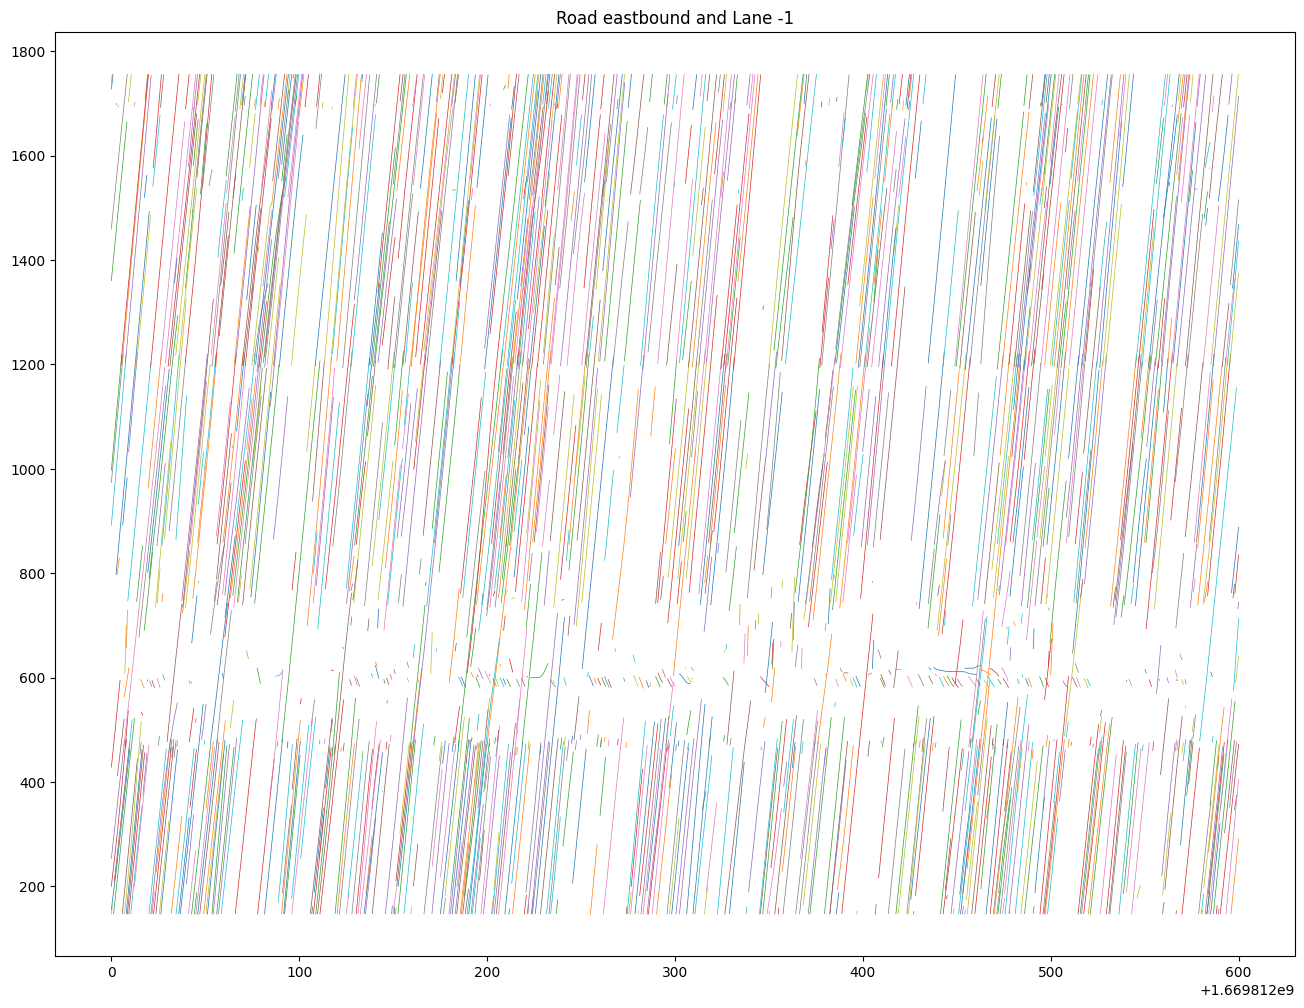

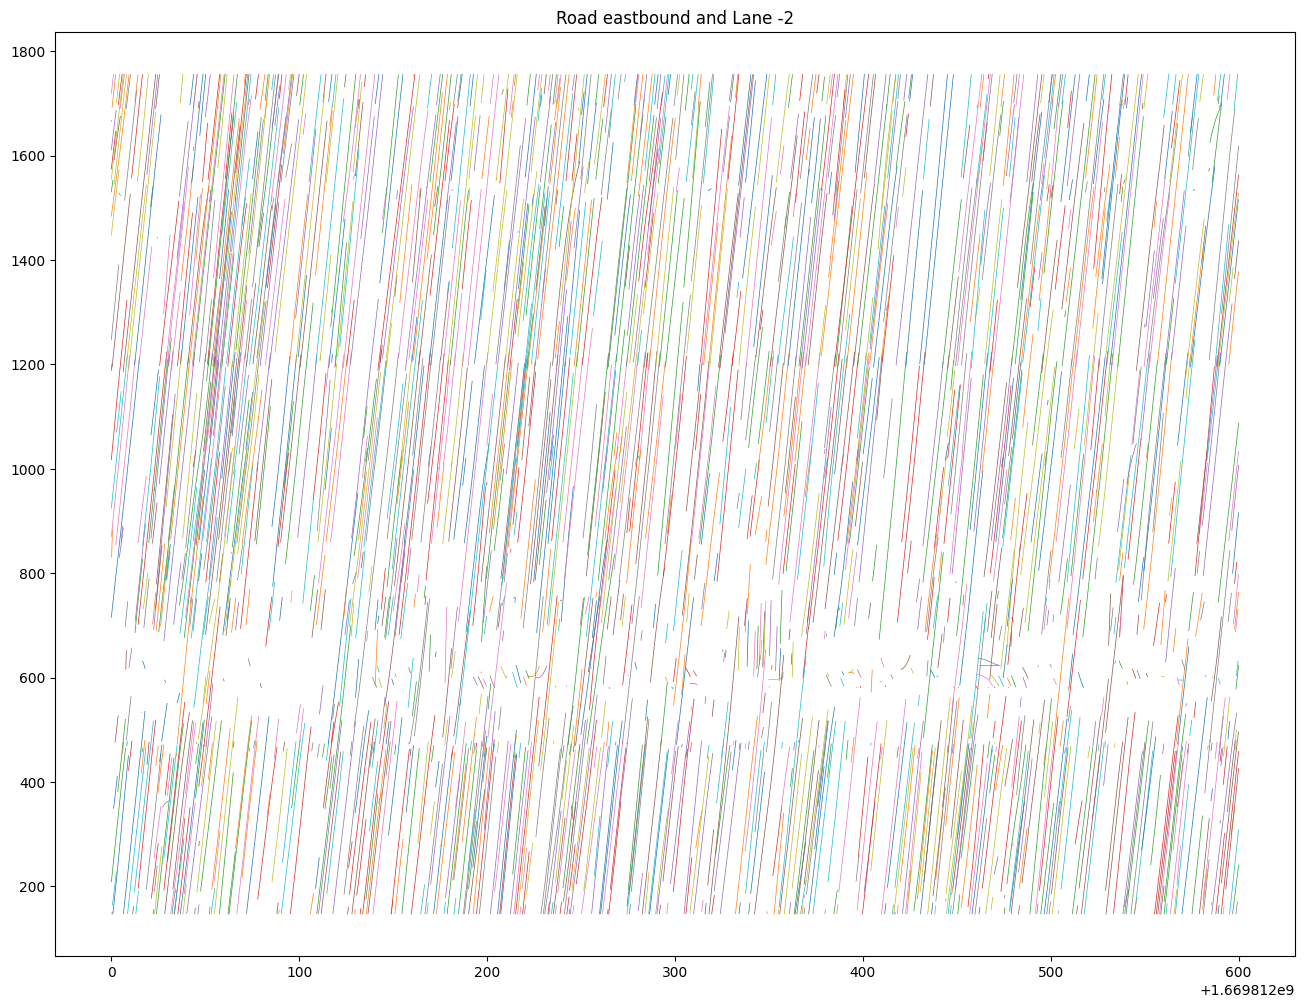

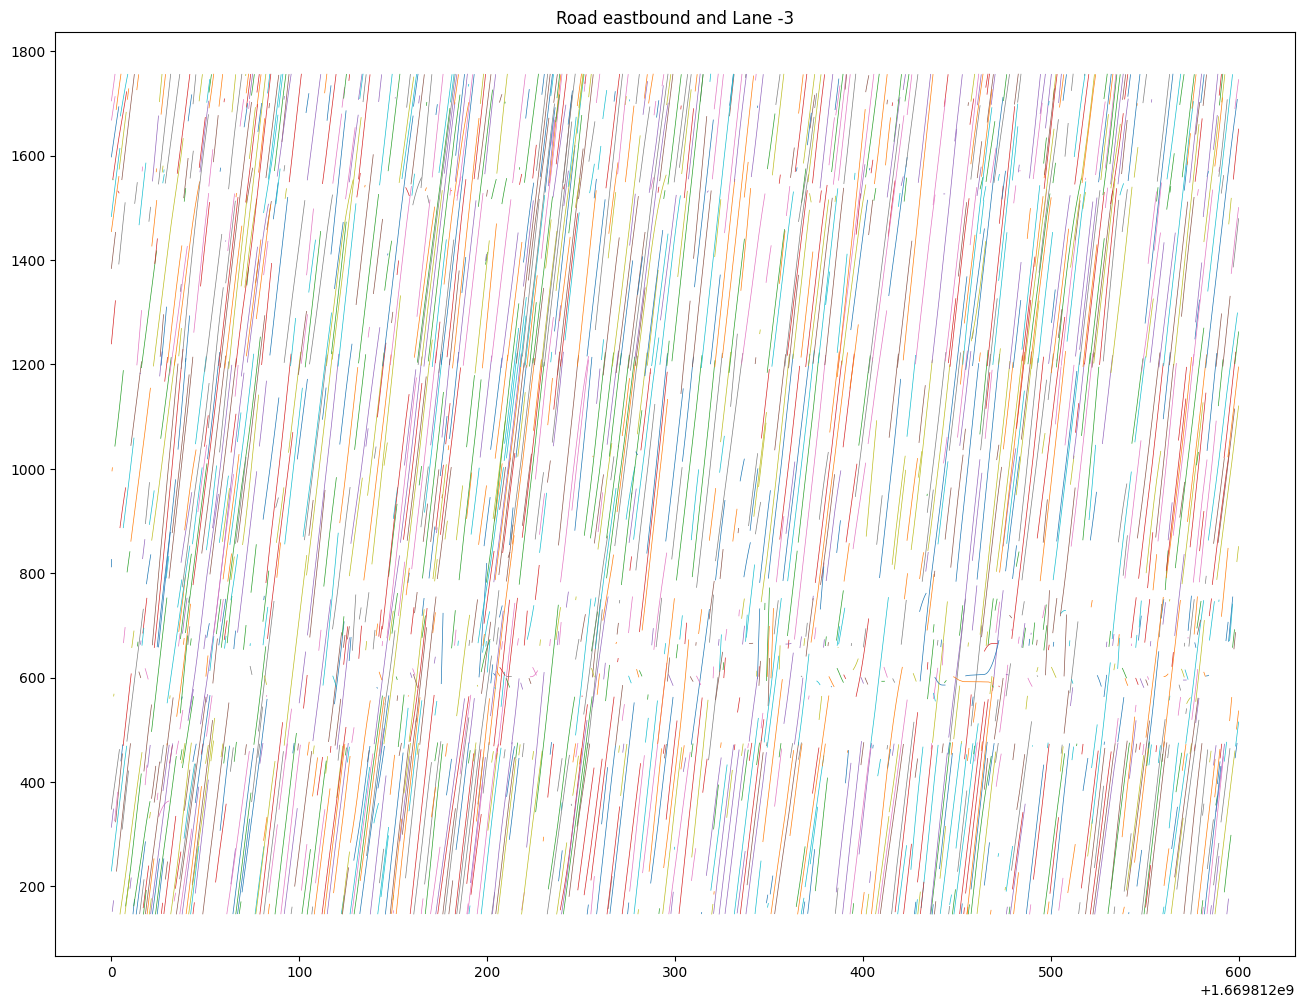

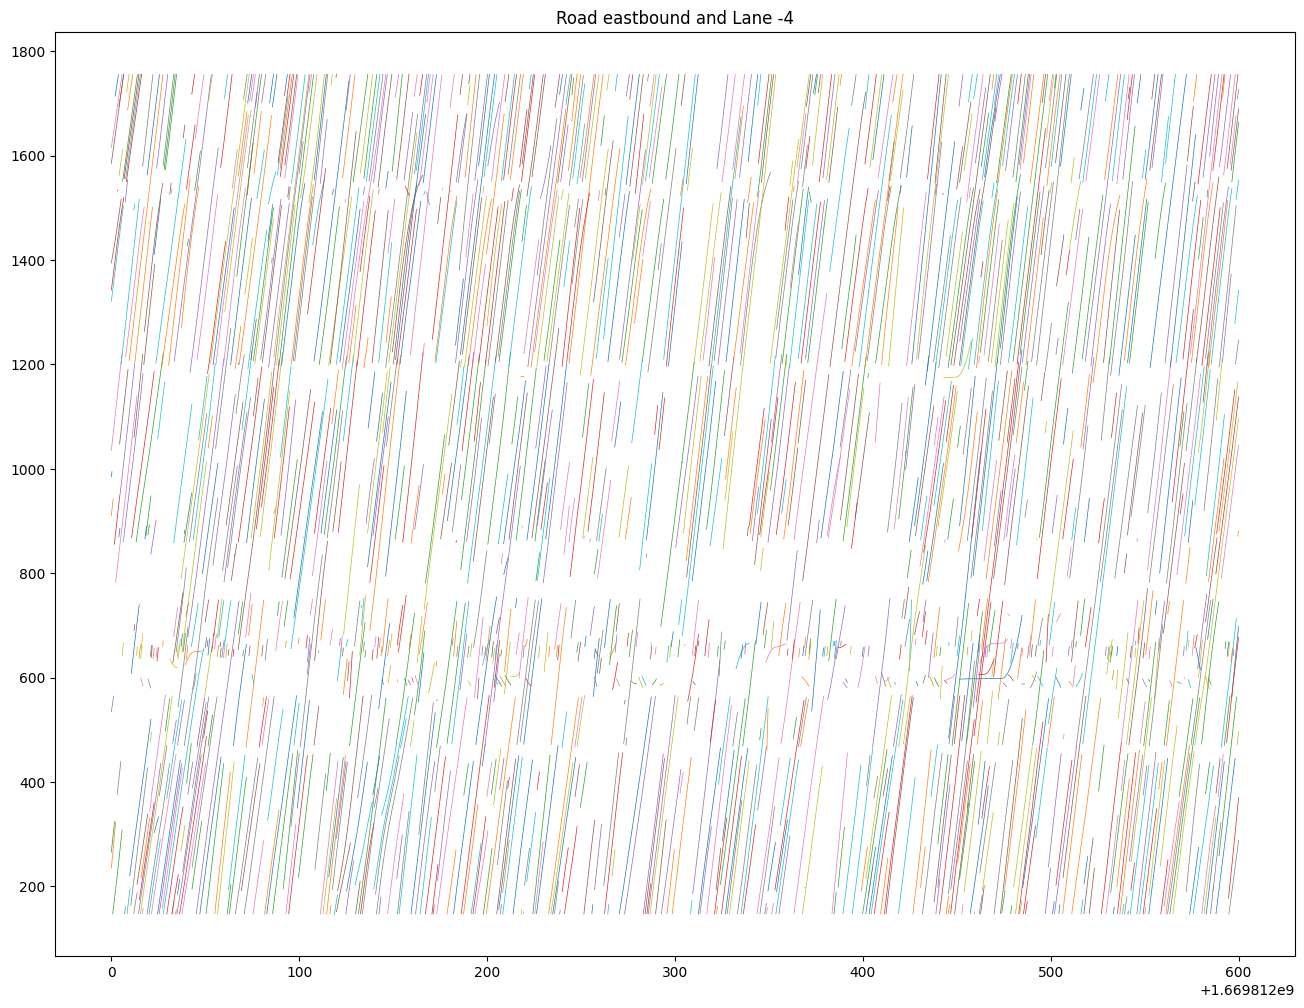

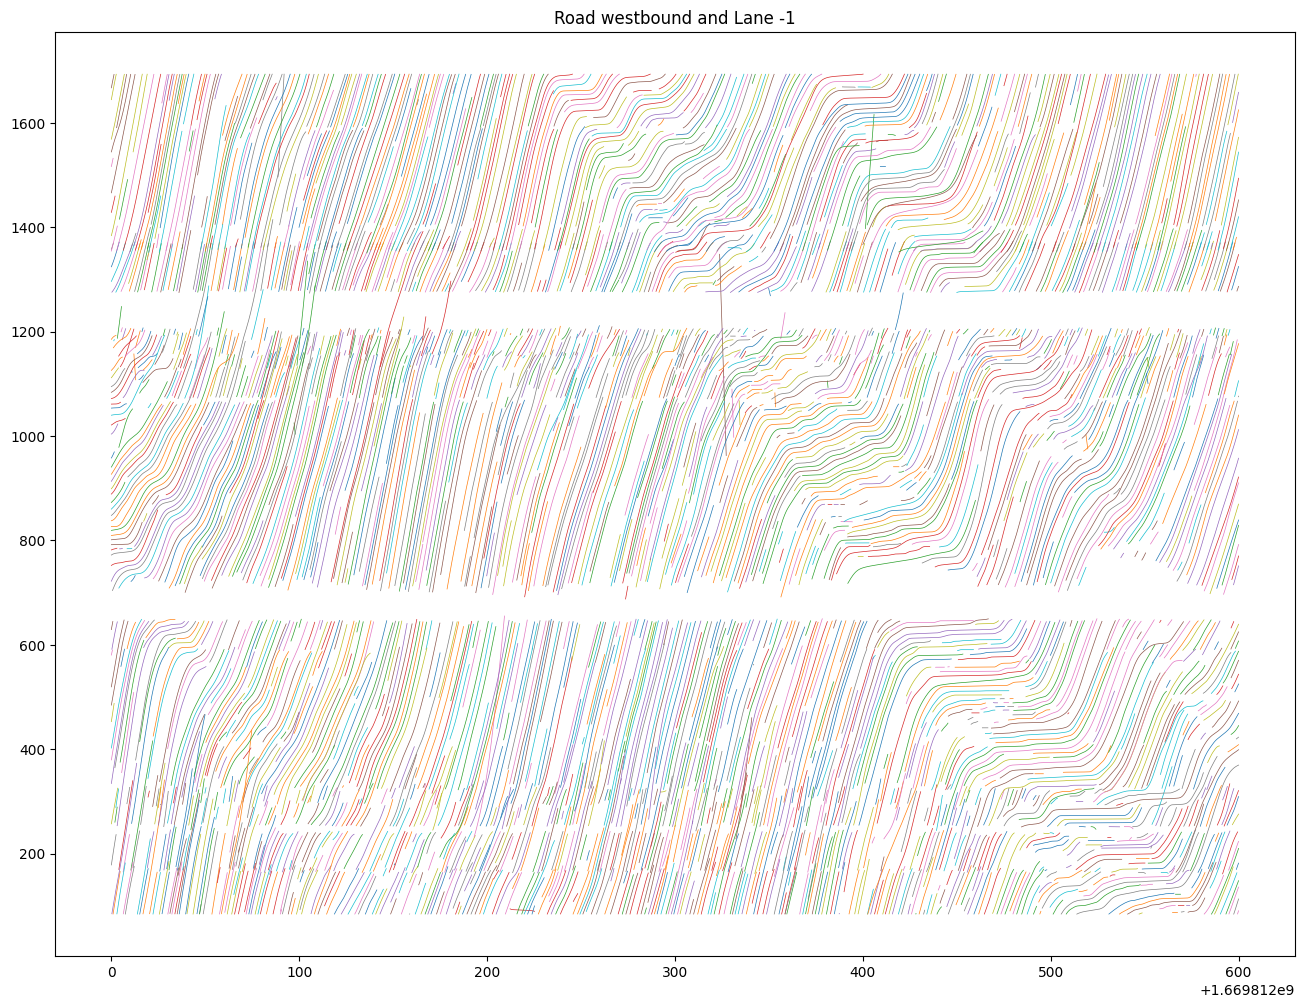

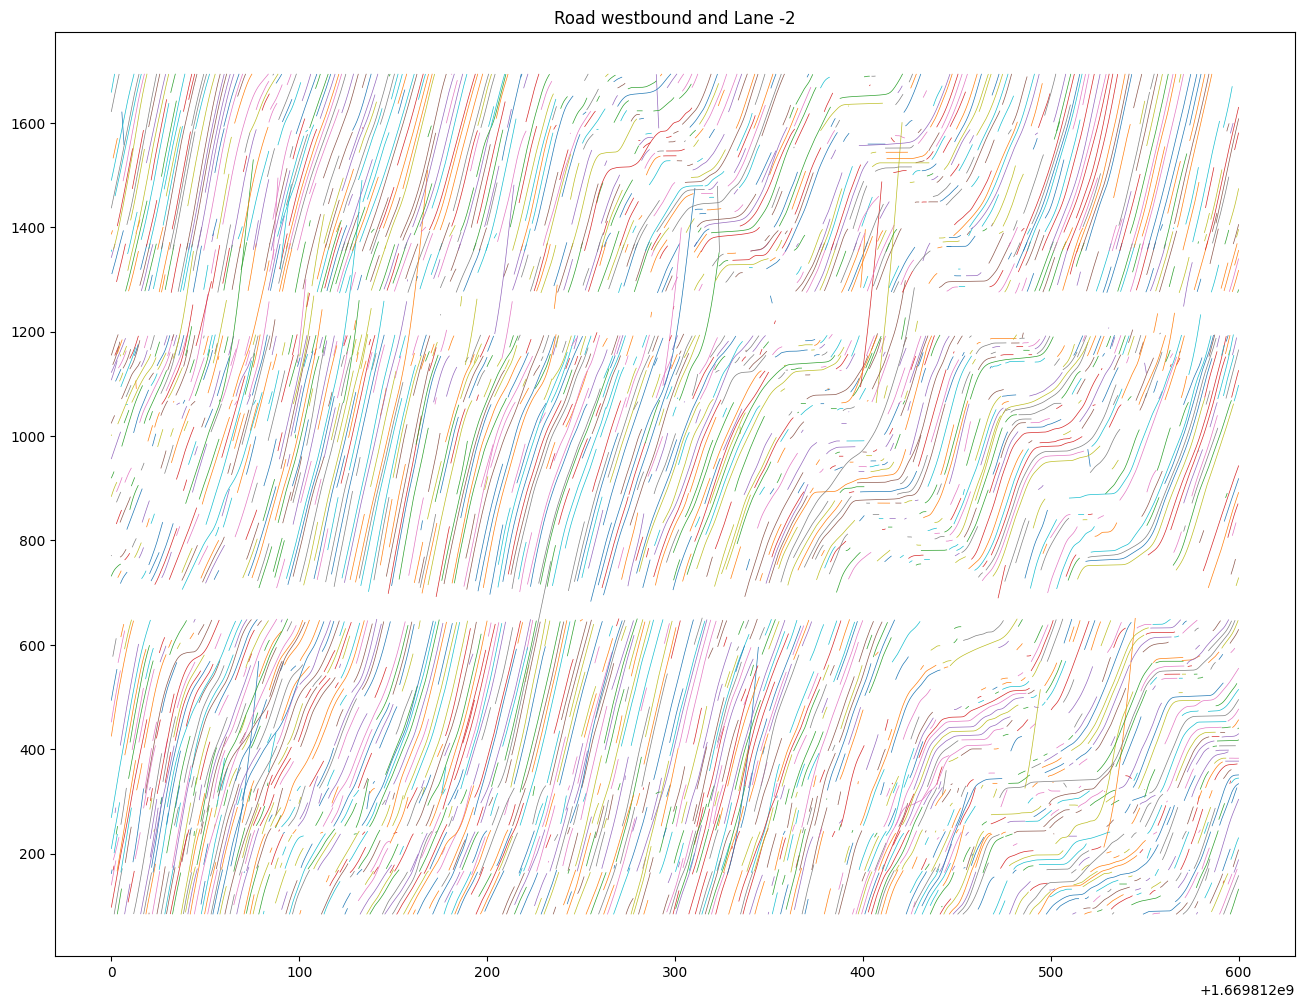

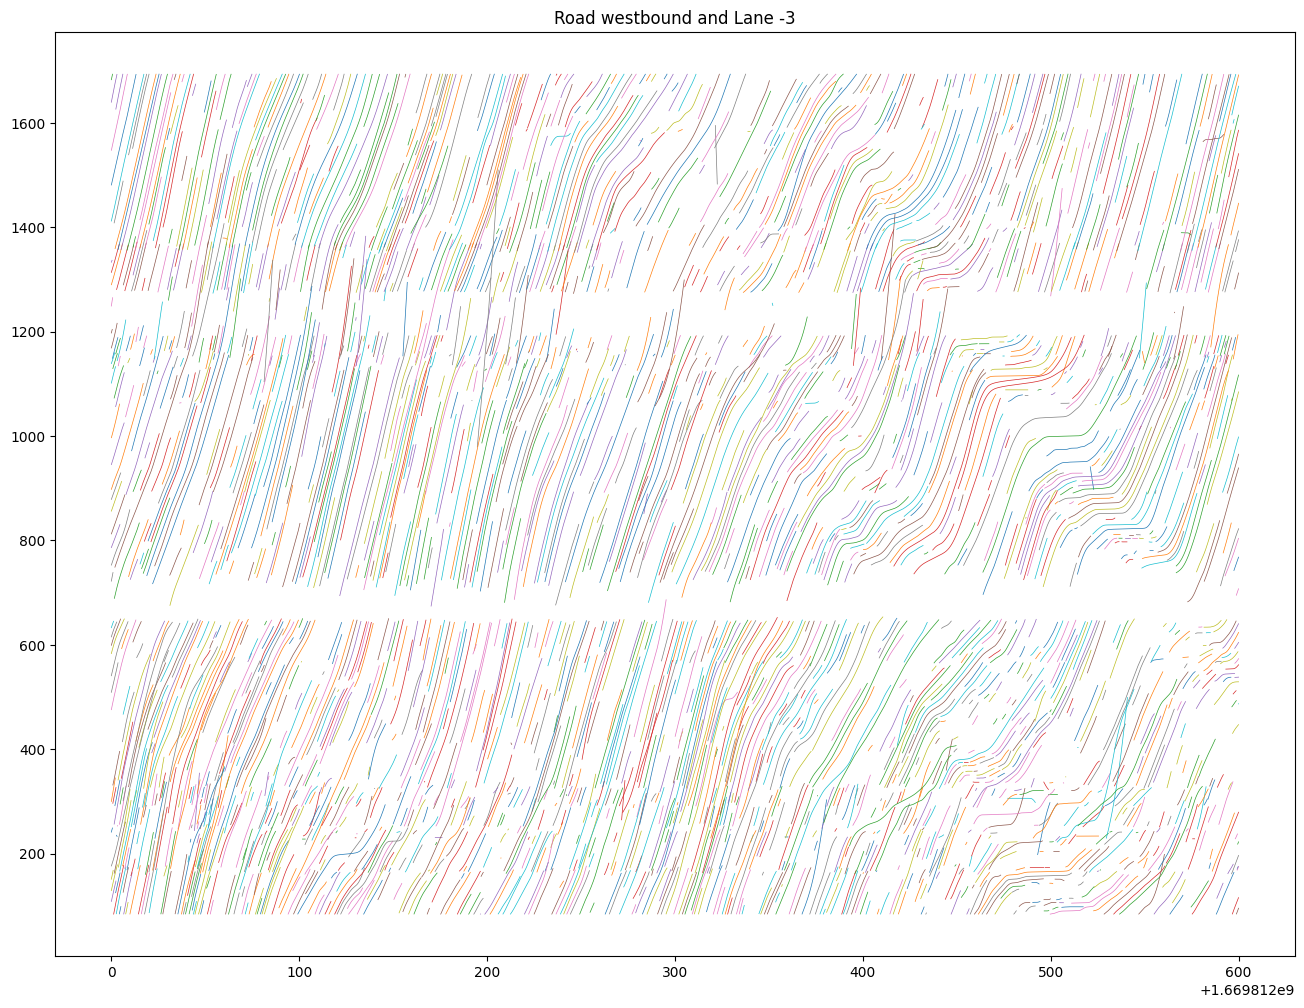

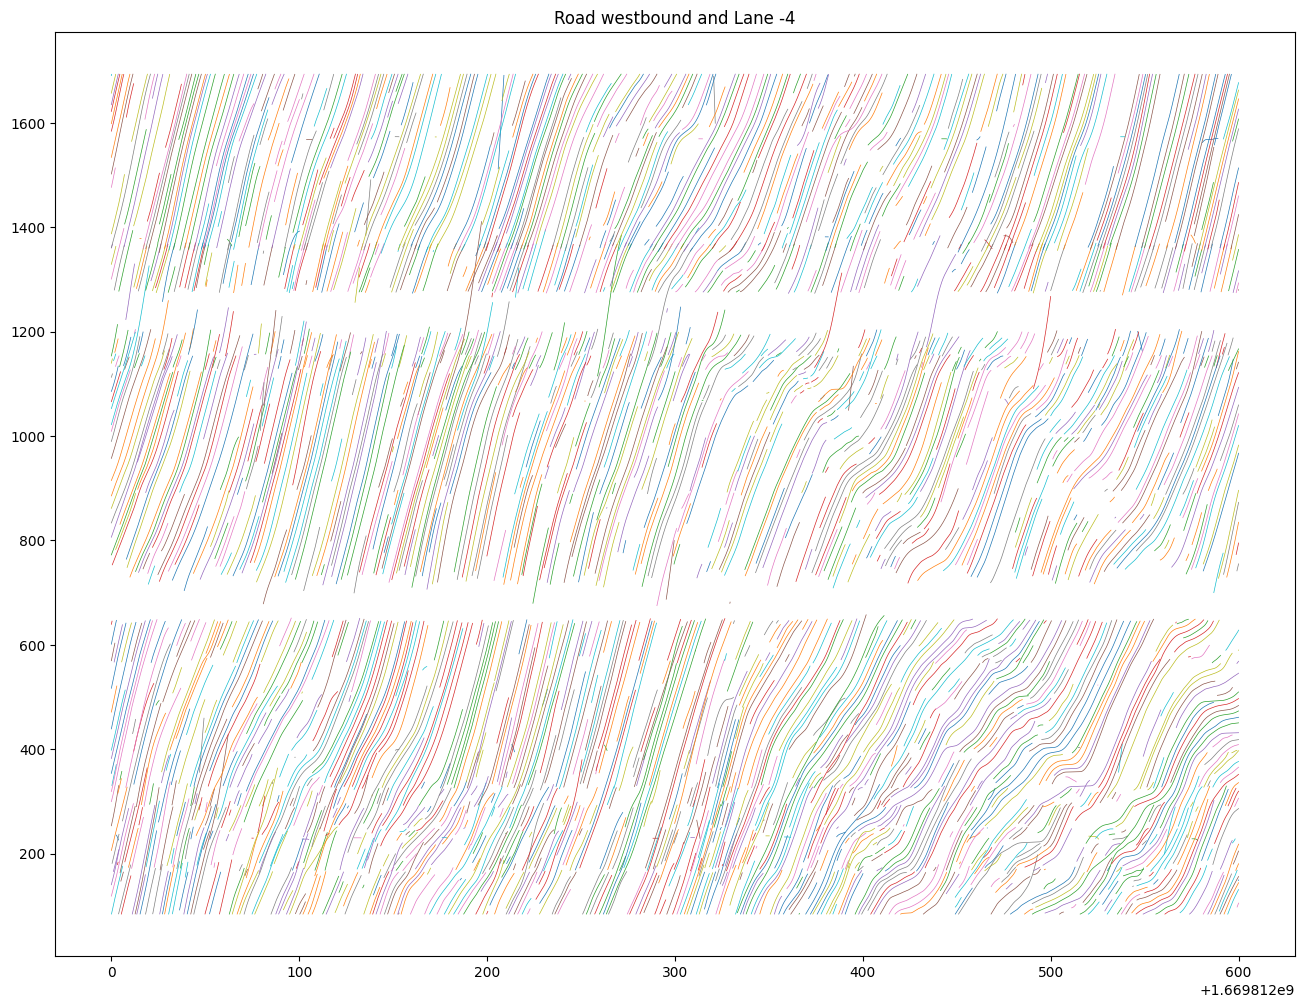

In [ ]:
import matplotlib.pyplot as plt

def plotRoadAndLane(data, road, lane):
    fig, ax = plt.subplots(figsize=(16, 12))
    for entry in data[road][lane]:
        ax.plot(entry["timestamp"], entry["s"], linewidth=0.5)
    ax.set_title(f"Road {road} and Lane {lane}")
    fig.show()


'''
for road in time_and_marker_and_lane_filtered_data:
    for lane in time_and_marker_and_lane_filtered_data[road]:
        plotRoadAndLane(time_and_marker_and_lane_filtered_data, road, lane)
'''


# Convert to estimated density

In [112]:
with open("../selected_map_region_10_minutes_opendrive.json", "r") as f:
    time_and_marker_and_lane_filtered_data = json.load(f)

In [ ]:
import numpy
import joblib
# Don't include the lane boundaries themselves
def giveAcceptedEdieBox(road, entry, min_marker, max_marker, min_timestamp, max_timestamp):
    potential_inflow_outflow =  [m for idx, (m, timestamp) in enumerate(zip(entry["marker"], entry["timestamp"])) if (timestamp >= min_timestamp) and (timestamp <= max_timestamp)]
    if road == "eastbound":
        inflow = any([(m > min_marker) for m in potential_inflow_outflow]) and any([(m < min_marker) for m in potential_inflow_outflow])
        outflow = any([(m > max_marker) for m in potential_inflow_outflow]) and any([(m < max_marker) for m in potential_inflow_outflow])
    elif road == "westbound":
        outflow = any([(m > min_marker) for m in potential_inflow_outflow]) and any([(m < min_marker) for m in potential_inflow_outflow])
        inflow = any([(m > max_marker) for m in potential_inflow_outflow]) and any([(m < max_marker) for m in potential_inflow_outflow])
    result = [idx for idx, (m, timestamp) in enumerate(zip(entry["marker"], entry["timestamp"])) if (m >= min_marker) and (m <= max_marker) and (timestamp >= min_timestamp) and (timestamp <= max_timestamp)]
    if len(result) == 0:
        return False, False, False, 0, 0
    return True, inflow, outflow, int(min(result)), int(max(result))

def filterEntryByEdieBox(road, entry, min_marker, max_marker, min_timestamp, max_timestamp):
    result = {}
    valid, inflow, outflow, min_index, max_index = giveAcceptedEdieBox(road, entry, min_marker, max_marker, min_timestamp, max_timestamp)
    if not valid:
        return None
    result["_id"] = entry["_id"]
    result["timestamp"] = filterArrayByIndex(entry["timestamp"], min_index, max_index)
    result["marker"] = filterArrayByIndex(entry["marker"], min_index, max_index)
    result["s"] = filterArrayByIndex(entry["s"], min_index, max_index)
    result["t"] = filterArrayByIndex(entry["t"], min_index, max_index)
    result["inflow"] = inflow
    result["outflow"] = outflow
    result["length"] = entry["length"]
    result["width"] = entry["width"]
    result["height"] = entry["height"]
    result["coarse_vehicle_class"] = entry["coarse_vehicle_class"]
    result["fine_vehicle_class"] = entry["fine_vehicle_class"]
    result["direction"] = entry["direction"]
    return result

def filterDatasetByEdieBox(data, start_marker, end_marker, marker_interval, start_timestamp, end_timestamp, timestamp_interval):
    result = {}
    boxes = {}
    for m in numpy.arange(start_marker, end_marker, marker_interval):
        m = round(m, 2)
        boxes[m] = {}
        for timestamp in numpy.arange(start_timestamp, end_timestamp, timestamp_interval):
            timestamp = round(timestamp, 0)
            boxes[m][timestamp] = True # We just need the keys
    for road in data:
        result[road] = {}
        road_bounds = data[road]
        for lane in road_bounds:
            result[road][lane] = {}
            for m in boxes:
                result[road][lane][m] = {}
                for timestamp in boxes[m]:
                    result[road][lane][m][timestamp] = []
    for road in data:
        for lane in data[road]:
            for entry in data[road][lane]:
                for m in boxes:
                    for timestamp in boxes[m]:
                        filtered_entry = filterEntryByEdieBox(road, entry, m, m + marker_interval, timestamp, timestamp + timestamp_interval)
                        if filtered_entry is not None:
                            result[road][lane][m][timestamp].append(filtered_entry)

    return result


In [114]:
density_data = filterDatasetByEdieBox(time_and_marker_and_lane_filtered_data, 60.6, 61.6, 0.05, 1669812000.0, 1669812600.0, 1.0)

In [115]:
with open("../selected_map_region_density_and_outflow_10_minutes_opendrive_1s_delta.json", "w+") as f:
    json.dump(density_data, f, indent=4)

In [116]:
with open("../selected_map_region_density_and_outflow_10_minutes_opendrive_1s_delta.json", "r") as f:
    density_data = json.load(f)

In [96]:
len(density_data["westbound"]["-1"]["61.55"]["1669812000.0"])

3

In [ ]:
def generateFinalDensitiesAtSpaceAndTime(data):
    result = {}
    for road in data:
        result[road] = {}
        for lane in data[road]:
            result[road][lane] = {}
            for s in data[road][lane]:
                result[road][lane][s] = {}
                previous_vehicle_count = None
                previous_outflow = None
                for timestamp in data[road][lane][s]:
                    entry = {}
                    entry["vehicle_count"] = len(data[road][lane][s][timestamp])
                    entry["inflow"] = 0
                    entry["outflow"] = 0
                    estimated_outflow = 0
                    if previous_vehicle_count is not None:
                        estimated_outflow = max(previous_vehicle_count - entry["vehicle_count"], 0)
                    for vehicle_entry in data[road][lane][s][timestamp]:
                        if vehicle_entry["inflow"]:
                            entry["inflow"] = entry["inflow"] + 1
                        if vehicle_entry["outflow"]:
                            entry["outflow"] = entry["outflow"] + 1
                    #entry["outflow"] = max(entry["outflow"], estimated_outflow)
                    previous_vehicle_count = entry["vehicle_count"]
                    previous_outflow = entry["outflow"]
                    
                    result[road][lane][s][timestamp] = entry
    return result

In [121]:
final_density_data = generateFinalDensitiesAtSpaceAndTime(density_data)

In [99]:
final_density_data["westbound"]["-1"]["60.7"]

{'1669812000.0': {'vehicle_count': 4, 'inflow': 2, 'outflow': 1},
 '1669812005.0': {'vehicle_count': 3, 'inflow': 2, 'outflow': 1},
 '1669812010.0': {'vehicle_count': 2, 'inflow': 1, 'outflow': 1},
 '1669812015.0': {'vehicle_count': 3, 'inflow': 2, 'outflow': 1},
 '1669812020.0': {'vehicle_count': 6, 'inflow': 4, 'outflow': 2},
 '1669812025.0': {'vehicle_count': 7, 'inflow': 3, 'outflow': 4},
 '1669812030.0': {'vehicle_count': 4, 'inflow': 2, 'outflow': 3},
 '1669812035.0': {'vehicle_count': 3, 'inflow': 2, 'outflow': 1},
 '1669812040.0': {'vehicle_count': 4, 'inflow': 2, 'outflow': 2},
 '1669812045.0': {'vehicle_count': 2, 'inflow': 0, 'outflow': 2},
 '1669812050.0': {'vehicle_count': 2, 'inflow': 2, 'outflow': 0},
 '1669812055.0': {'vehicle_count': 5, 'inflow': 4, 'outflow': 2},
 '1669812060.0': {'vehicle_count': 5, 'inflow': 2, 'outflow': 3},
 '1669812065.0': {'vehicle_count': 4, 'inflow': 2, 'outflow': 2},
 '1669812070.0': {'vehicle_count': 4, 'inflow': 2, 'outflow': 3},
 '16698120

In [122]:
packaged_final_density = {}
packaged_final_density["time_start"] = 1669812000.0
packaged_final_density["time_end"] = 1669812600.0
packaged_final_density["time_interval"] = 1.0
packaged_final_density["x_marker_start"] = 60.6
packaged_final_density["x_marker_end"] = 61.6
packaged_final_density["x_marker_interval"] = 0.05
packaged_final_density["data"] = final_density_data

with open("../final_density_data_1s_delta.json", "w+") as f:
    json.dump(packaged_final_density, f, indent=4)